In [1]:
# 패션 MNIST 데이터 불러오기
import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
# 데이터 스케일을 0〜255 사이에서 0〜1 사이로 바꾸기
# 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않음(flatten 클래스 x)
# but, Conv2D 층을 사용하기 위해 입력 이미지는 항상 깊이(채널) 차원이 있어야 함
# reshape() 메서드를 사용하여 전체 배열 차원을 그대로 유지하면서 마지막에 채널 차원 추가
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# 훈련 세트와 검증 세트로 나눕
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

2025-11-27 10:45:18.342236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 10:45:18.380036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764207918.410583    1168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764207918.420196    1168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 10:45:18.464096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

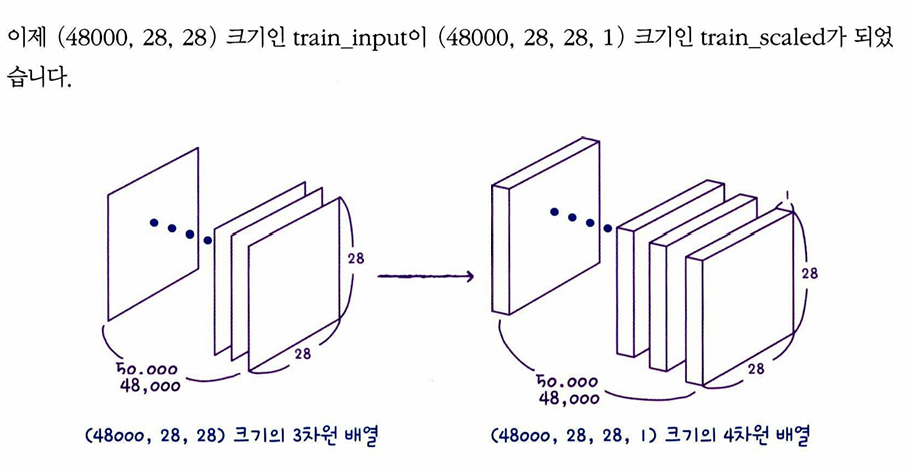

#### 합성곱 신경망 만들기
합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산

In [2]:
# Sequential 클래스의 객체 생성
model = keras.Sequential()
# 입력층 추가
model.add(keras.layers.Input(shape=(28,28,1)))
# 첫 번째 합성곱 층인 Conv2D 추가
# 32개의 필터를 사용, 커널의 크기는(3, 3)이고 렐루 활성화 함수와 세임 패딩을 사용
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))

I0000 00:00:1764207967.429917    1168 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 4GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# 풀링 층 추가
# Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정 가능
model.add(keras.layers.MaxPooling2D(2))

In [4]:
# 두 번째 합성곱-풀링 층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [5]:
# 3차원 특성 맵을 일렬로 펼칠 차례 - 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문
model.add(keras.layers.Flatten())
# 밀집 은닉층
model.add(keras.layers.Dense(100, activation='relu'))
# 드롭아웃 : 은닉층의 과대적합을 막아 성능 개선
model.add(keras.layers.Dropout(0.4))
# 출력층
model.add(keras.layers.Dense(10, activation='softmax'))

In [6]:
# 모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

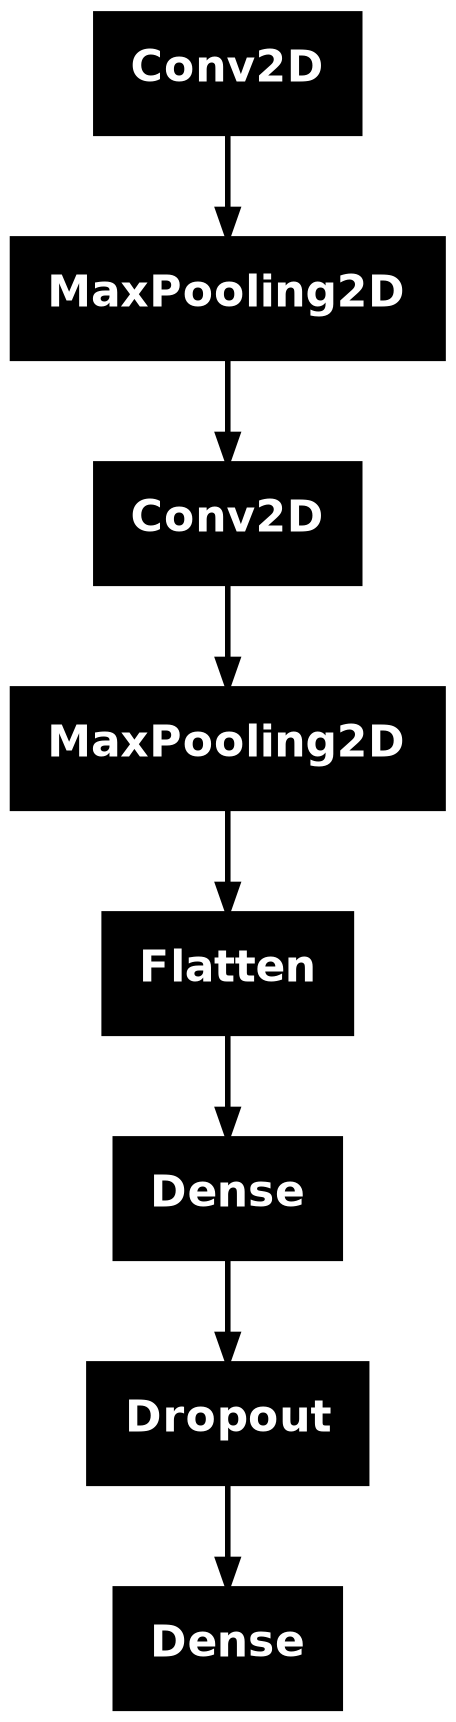

In [8]:
# 층의 구성을 그림으로 표현
keras.utils.plot_model(model)

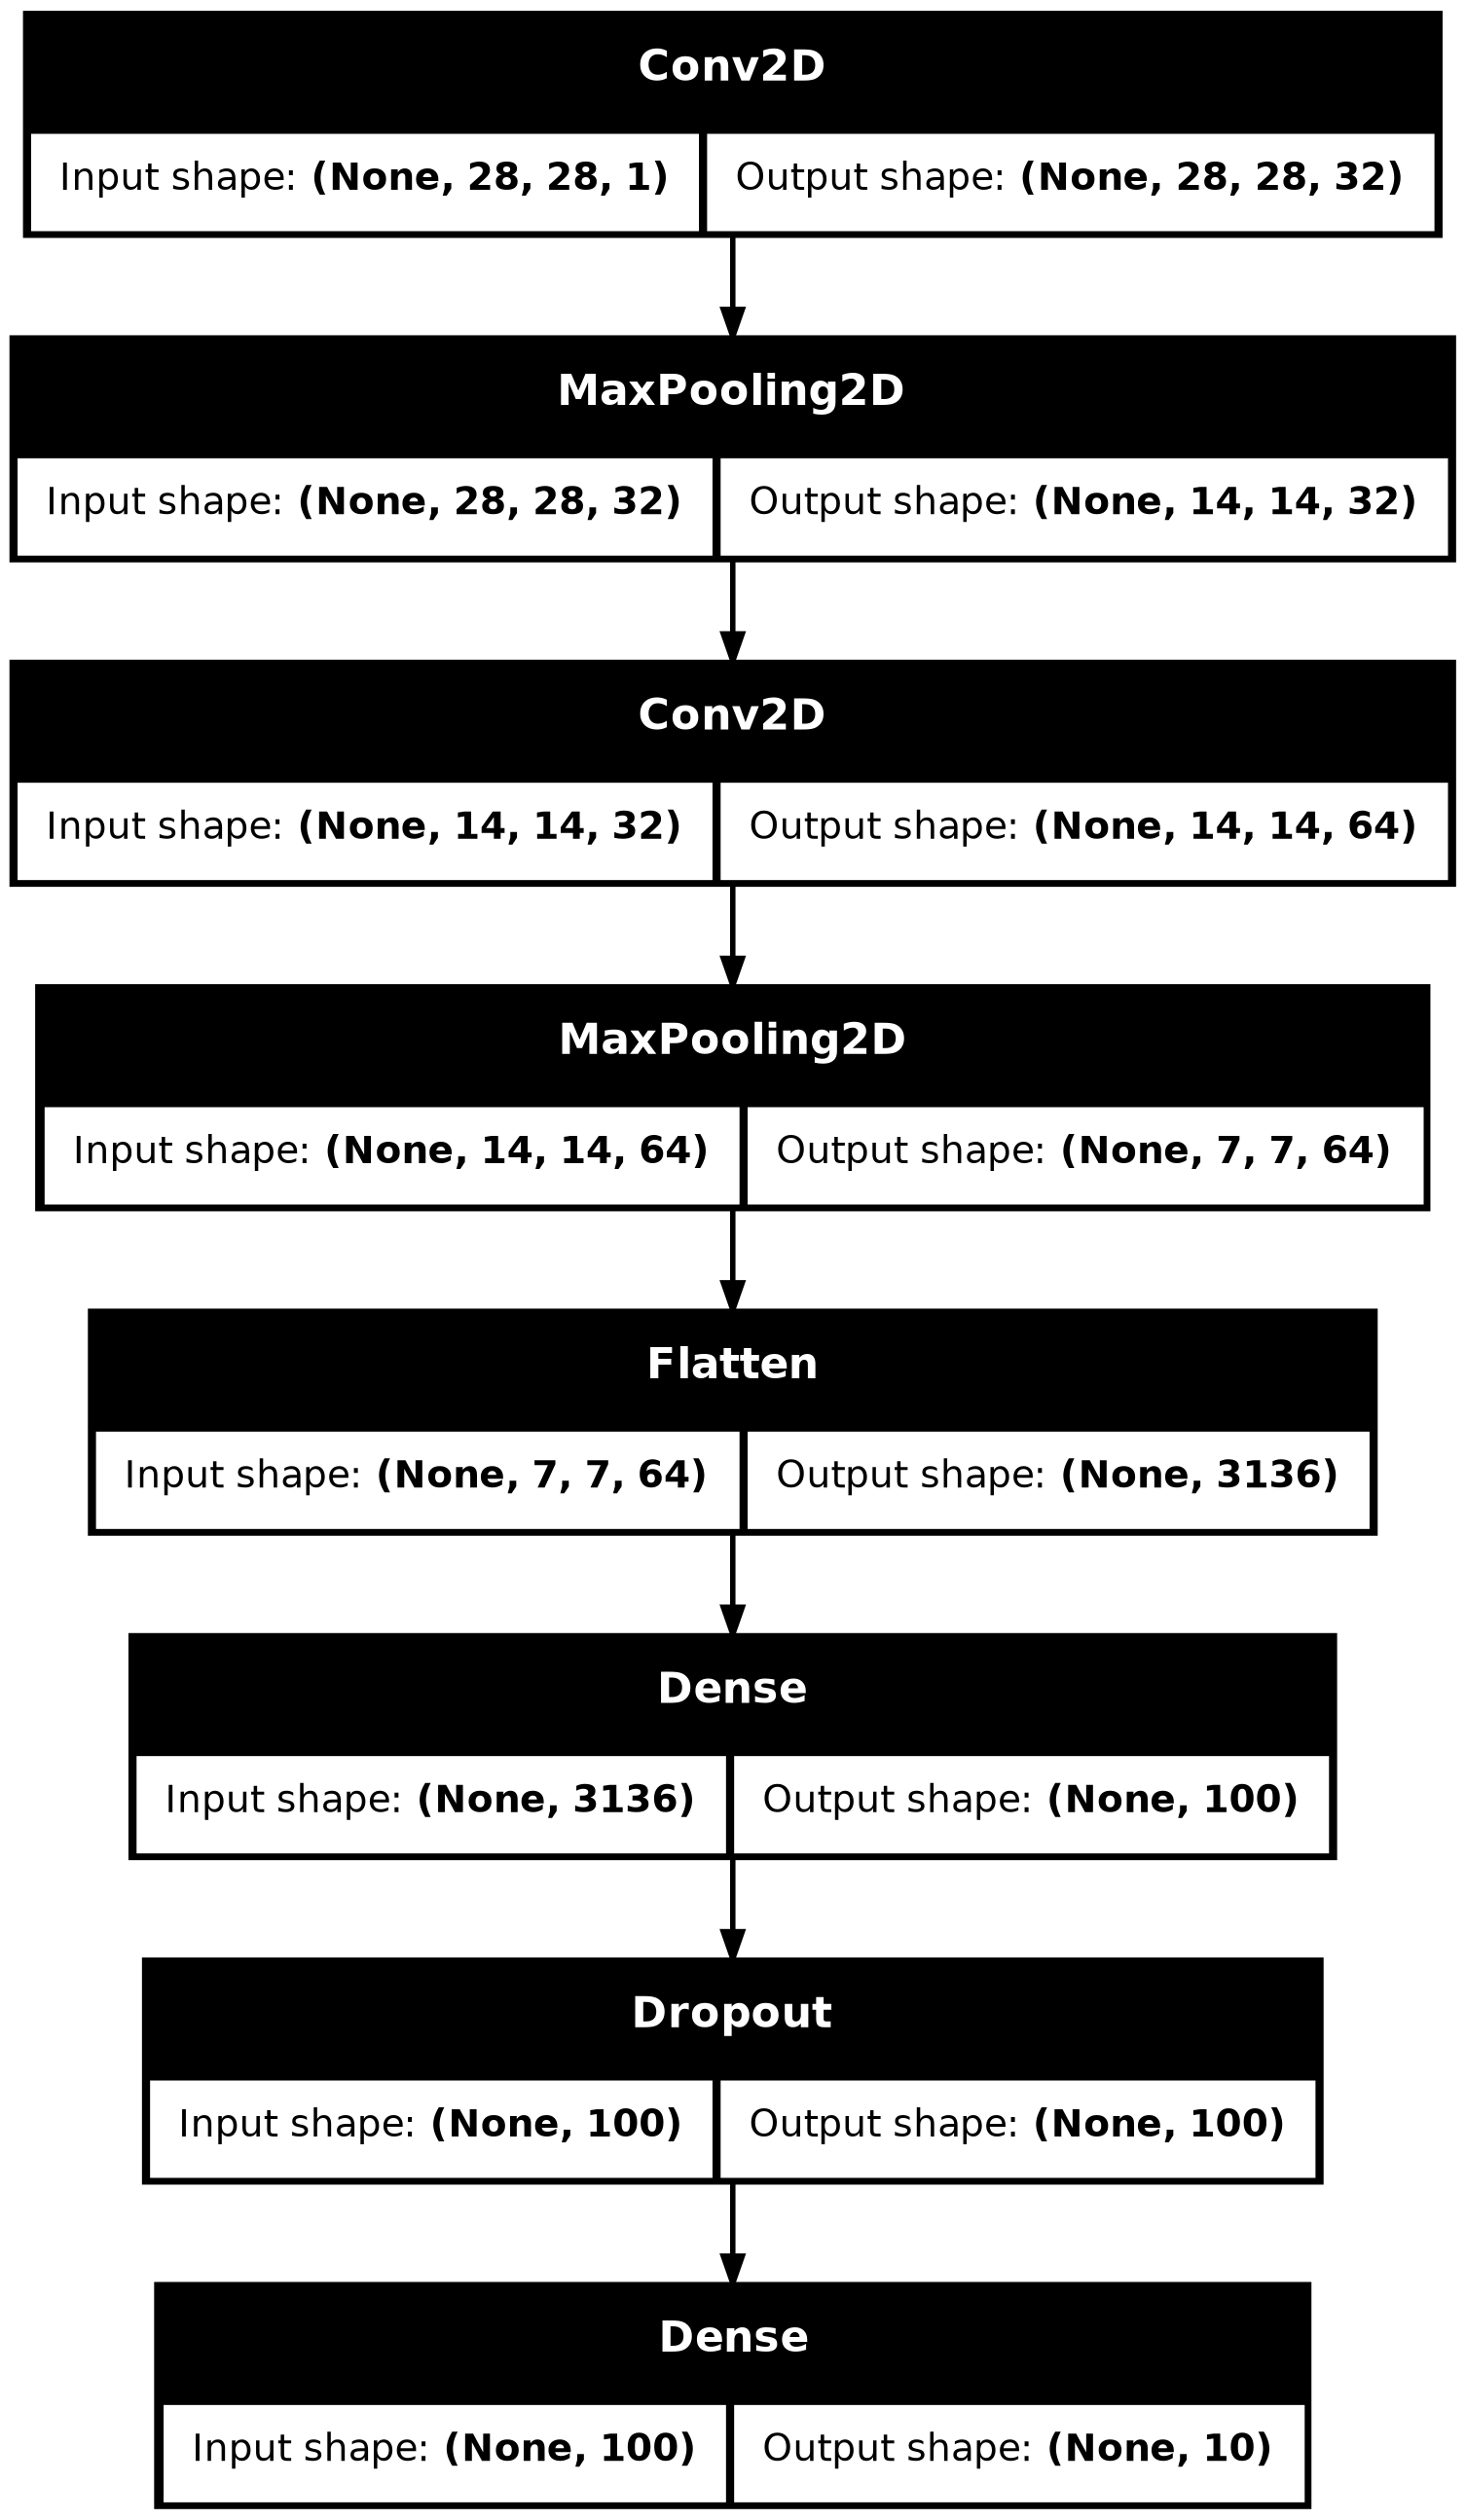

In [9]:
#  show_shapes = True : 입력과 출력의 크기 표시
keras.utils.plot_model(model, show_shapes=True)

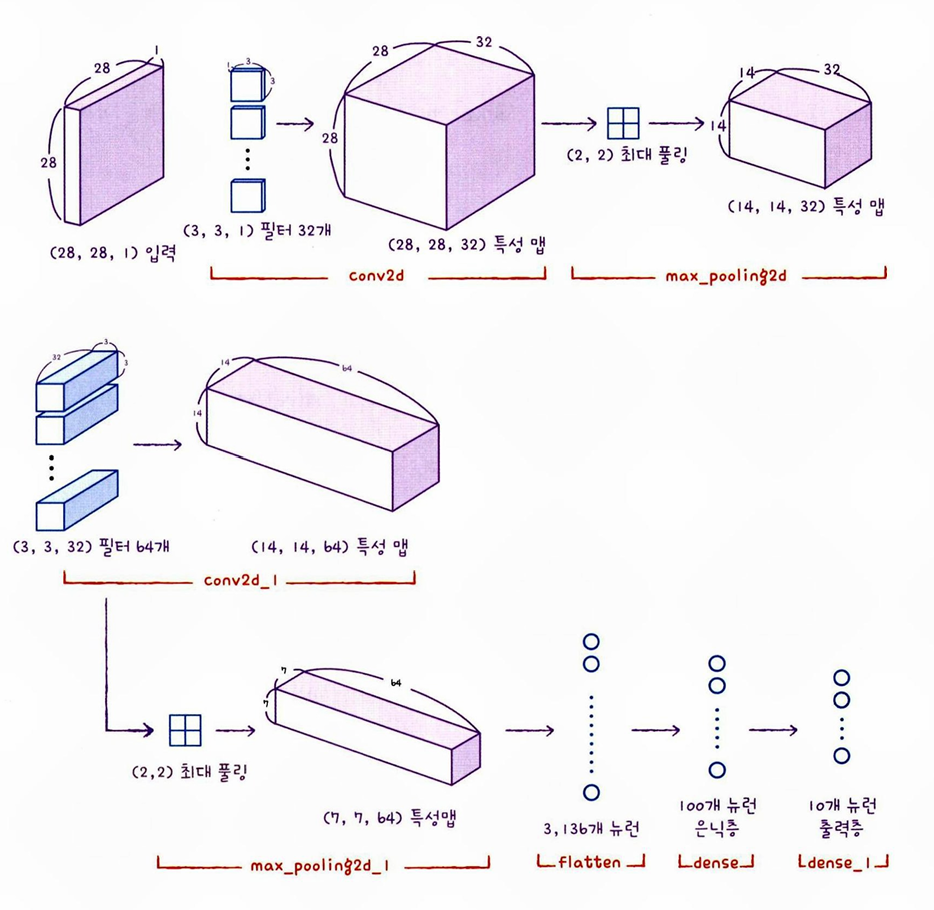

#### 모델 컴파일과 훈련

In [10]:
#  Adam 옵티마이저를 사용하고 Modelcheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20


I0000 00:00:1764208070.935843   21545 service.cc:148] XLA service 0x78ecc800b1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764208070.935917   21545 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 4GB Laptop GPU, Compute Capability 8.6
2025-11-27 10:47:50.966639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764208071.104879   21545 cuda_dnn.cc:529] Loaded cuDNN version 91002


  40/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3347 - loss: 1.8591

I0000 00:00:1764208073.365794   21545 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7292 - loss: 0.7465 - val_accuracy: 0.8798 - val_loss: 0.3296
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8690 - loss: 0.3686 - val_accuracy: 0.8964 - val_loss: 0.2832
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8868 - loss: 0.3125 - val_accuracy: 0.9043 - val_loss: 0.2533
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8980 - loss: 0.2805 - val_accuracy: 0.9057 - val_loss: 0.2546
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9063 - loss: 0.2540 - val_accuracy: 0.9118 - val_loss: 0.2319
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9190 - loss: 0.2283 - val_accuracy: 0.9175 - val_loss: 0.2216
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9226 - loss: 0.2077 - val_accuracy: 0.9168 - val_loss: 0.2196
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9288 - loss: 0.1892 - val_accura

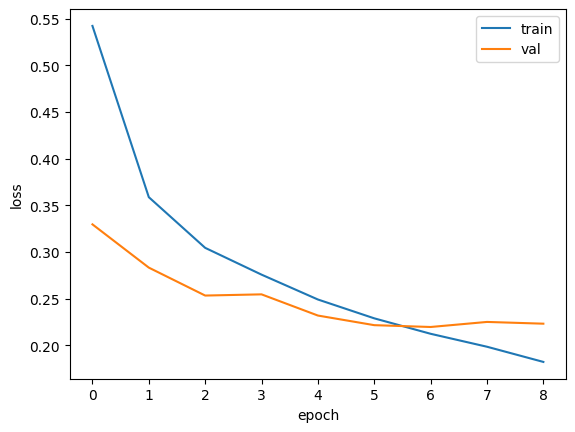

In [11]:
# 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
# 검증 세트로 최적의 에포크에서 성능 평가
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9181 - loss: 0.2172


[0.2196476310491562, 0.9167500138282776]

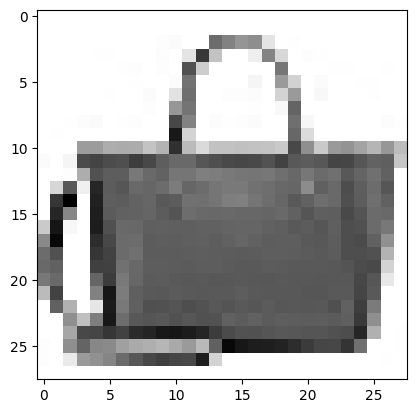

In [13]:
# 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [14]:
# 훈련된 모델을 사용하여 새로운 데이터에 대해 예측
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
[[2.2390960e-15 7.7106526e-22 9.1274852e-19 9.8634116e-18 1.6819480e-19
  1.6451904e-15 2.0479940e-17 2.6257254e-18 1.0000000e+00 7.4561471e-19]]


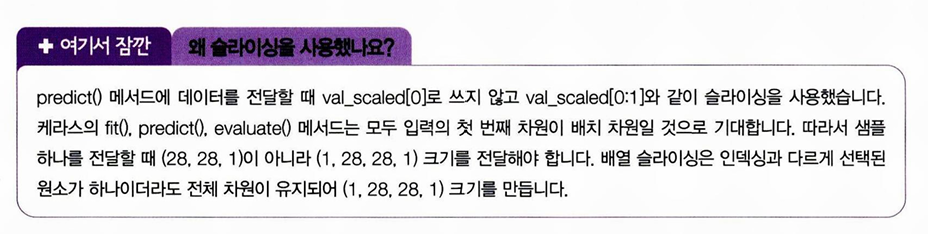

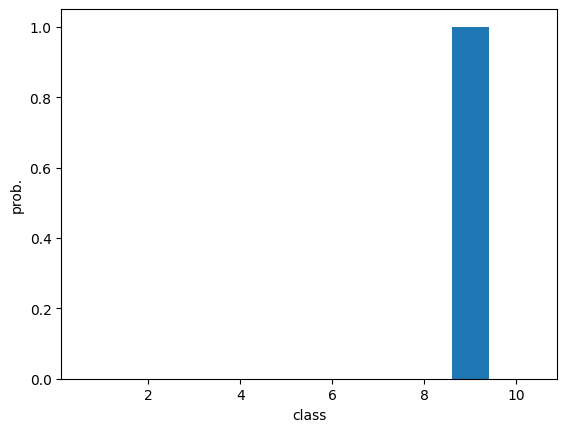

In [15]:
# 10개의 클래스에 대한 예측 확률 막대그래프
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [16]:
# 패션 MNIST 데이터셋의 레이블
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [17]:
# 레이블 출력 : preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용
import numpy as np
print(classes[np.argmax(preds)])

가방


In [18]:
# 이제까지 사용하지 않았던 테스트 세트를 사용해 최종 모델의 일반화 성능을 평가 - 모델을 출시하기 직전 딱 한 번만 사용
# 픽셀값의 범위를 0〜1 사이로 바꾸고 채널 차원 추가
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9108 - loss: 0.2508


[0.24208740890026093, 0.9138000011444092]